# 1. clean the data



In [1]:
import pandas as pd
import re
import nltk
!pip install pyspellchecker
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
import gc
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.4 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# loading the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# clean data
def clean_text(text):
    text = re.sub(r'http\S+', '<url>', text)
    text = re.sub(r'@\w+', '<user>', text)
    text = re.sub(r'#\w+', '<hashtag>', text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [3]:
print(train_df[['text', 'cleaned_text']].head())
print(test_df[['text', 'cleaned_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0  our deeds are the reason of this hashtag may a...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3   people receive hashtag evacuation orders in c...  
4  just got sent this photo from ruby hashtag as ...  
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan 

# 2. Feature Engineering and Preprocessing

In [4]:
def cross_validate_model(model, X, y, cv=10):
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return f1_scores.mean()

In [5]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(train_df['cleaned_text'])

X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, train_df['target'], test_size=0.2, random_state=42)

svm_model = SVC()

tfidf_f1_score = cross_validate_model(svm_model, X_tfidf, train_df['target'])

In [6]:
# Word2Vec
sentences = [text.split() for text in train_df['cleaned_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_features(text, model):
    words = text.split()
    features = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    return features

X_w2v = np.array([get_w2v_features(text, w2v_model) for text in train_df['cleaned_text']])

X_train_w2v, X_val_w2v, y_train, y_val = train_test_split(X_w2v, train_df['target'], test_size=0.2, random_state=42)

w2v_f1_score = cross_validate_model(svm_model, X_w2v, train_df['target'])

In [7]:
# Glove
def load_glove_model(glove_file):
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
    return model

glove_model = load_glove_model('glove.6B.50d.txt')

def get_glove_features(text, model):
    words = text.split()
    features = np.mean([model[word] for word in words if word in model], axis=0)
    if np.isnan(features).any():
        return np.zeros(50)
    return features

def handle_missing_features(features):
    if np.isnan(features).any():
        return np.zeros(features.shape)
    return features

X_glove = np.array([handle_missing_features(get_glove_features(text, glove_model)) for text in train_df['cleaned_text']])

X_train_glove, X_val_glove, y_train, y_val = train_test_split(X_glove, train_df['target'], test_size=0.2, random_state=42)

def cross_validate_model(model, X, y, cv=10):
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return f1_scores.mean()

svm_model = SVC()
glove_f1_score = cross_validate_model(svm_model, X_glove, train_df['target'])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

texts = train_df['cleaned_text']
target = train_df['target']

train_input_ids, train_attention_masks = bert_encode(texts, 60)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def extract_bert_features(input_ids, attention_masks, bert_model):
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }
    outputs = bert_model(inputs)
    return outputs.last_hidden_state

def extract_bert_features_in_batches(input_ids, attention_masks, bert_model, batch_size=8):
    features = []
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]
        batch_features = extract_bert_features(batch_input_ids, batch_attention_masks, bert_model)
        features.append(batch_features)
    return np.vstack(features)

train_features = extract_bert_features_in_batches(train_input_ids, train_attention_masks, bert_model, batch_size=8)

del train_input_ids, train_attention_masks
gc.collect()

def mean_pooling(features):
    return np.mean(features, axis=1)

train_features_pooled = mean_pooling(train_features)

def cross_validate_model(model, X, y, cv=10):
    f1_scorer = make_scorer(f1_score)
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)
    return f1_scores.mean()

logistic_model = LogisticRegression(max_iter=1000)
logistic_f1_score = cross_validate_model(logistic_model, train_features_pooled, target)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def cross_validate_model(model, X, y, cv=5):
    from sklearn.model_selection import cross_validate

    scoring = {'accuracy': 'accuracy',
               'precision': 'precision',
               'recall': 'recall',
               'f1': 'f1'}

    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

    return {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean()
    }

tfidf_scores = cross_validate_model(svm_model, X_tfidf, train_df['target'])

w2v_scores = cross_validate_model(svm_model, X_w2v, train_df['target'])

glove_scores = cross_validate_model(svm_model, X_glove, train_df['target'])

bert_scores = cross_validate_model(logistic_model, train_features_pooled, target)

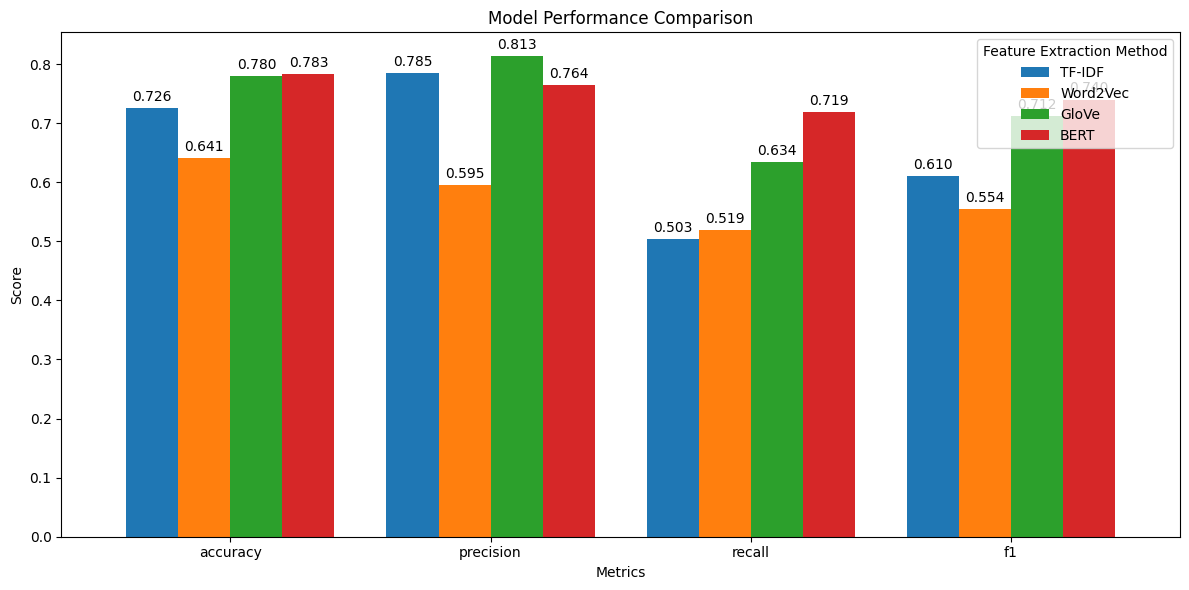

           TF-IDF  Word2Vec  GloVe  BERT
accuracy    0.726     0.641  0.780 0.783
precision   0.785     0.595  0.813 0.764
recall      0.503     0.519  0.634 0.719
f1          0.610     0.554  0.712 0.740


In [12]:
import pandas as pd

results = pd.DataFrame({
    'TF-IDF': tfidf_scores,
    'Word2Vec': w2v_scores,
    'GloVe': glove_scores,
    'BERT': bert_scores
})

import matplotlib.pyplot as plt

ax = results.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Feature Extraction Method')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

print(results.to_string(float_format='{:.3f}'.format))

I compare the four feature extraction methods which are TF-IDF, Word2Vec, GloVe, and BERT, from the results of performance across accuracy, precision, recall, and F1-score metrics. While GloVe showed strong performance in accuracy(0.780) and precision(0.813), but BERT demonstrated the best overall balance across all metrics with highest accuracy(0.783) and F1-score(0.740). BERT's strength lies in its capacity to capture contextual nuances and semantic relationships in text, thanks to its deep bidirectional architecture and pre-training on vast corpora. This allows BERT to understand complex language patterns and generalize well to our specific task. Given the overall perfomance across all metrics, spcially from the high recall and F1-score, BERT has the most suitable choice for our text classification task.

# 3. MODEL DEVELOPMENT

In [13]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

def cross_validate_model(model, X, y, cv=10):
    f1_scorer = make_scorer(f1_score)
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)
    return f1_scores.mean()

In [14]:
#SVM model
svm_model = SVC()
svm_f1_score = cross_validate_model(svm_model, train_features_pooled, target)

In [15]:
# LSTM model
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(128, return_sequences=False),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def cross_validate_lstm_model(X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_shape = (X_train.shape[1], X_train.shape[2])
        lstm_model = create_lstm_model(input_shape)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8)

        lstm_model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=3,
            verbose=1
        )

        y_pred = (lstm_model.predict(X_val) > 0.5).astype("int32")
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        print(f"Fold F1 Score: {f1}")

    print(f"Mean LSTM F1 Score: {np.mean(f1_scores)}")
    return np.mean(f1_scores)

lstm_f1_score = cross_validate_lstm_model(train_features, target)

Epoch 1/3
762/762 [==============================] - 24s 8ms/step - loss: 0.6363 - accuracy: 0.6686 - val_loss: 0.5699 - val_accuracy: 0.7610
Epoch 2/3
762/762 [==============================] - 5s 6ms/step - loss: 0.5362 - accuracy: 0.7603 - val_loss: 0.4991 - val_accuracy: 0.7787
Epoch 3/3
48/48 [==============================] - 1s 5ms/step
Fold F1 Score: 0.7391304347826089
Epoch 1/3
762/762 [==============================] - 8s 7ms/step - loss: 0.6147 - accuracy: 0.6844 - val_loss: 0.5422 - val_accuracy: 0.7722
Epoch 2/3
762/762 [==============================] - 5s 6ms/step - loss: 0.5156 - accuracy: 0.7695 - val_loss: 0.4747 - val_accuracy: 0.7846
Epoch 3/3
48/48 [==============================] - 1s 4ms/step
Fold F1 Score: 0.746341463414634
Epoch 1/3
762/762 [==============================] - 8s 7ms/step - loss: 0.6344 - accuracy: 0.6586 - val_loss: 0.5632 - val_accuracy: 0.7682
Epoch 2/3
762/762 [==============================] - 5s 6ms/step - loss: 0.5423 - accuracy: 0.7511 - 

In [16]:
# GRU model
def create_gru_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.GRU(128, return_sequences=False),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def cross_validate_gru_model(X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_shape = (X_train.shape[1], X_train.shape[2])
        gru_model = create_gru_model(input_shape)

        gru_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=3,
            batch_size=8,
            verbose=1
        )

        y_pred = (gru_model.predict(X_val) > 0.5).astype("int32")
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        print(f"Fold F1 Score: {f1}")

    print(f"Mean GRU F1 Score: {np.mean(f1_scores)}")
    return np.mean(f1_scores)

gru_f1_score = cross_validate_gru_model(train_features, target)

Epoch 1/3
762/762 [==============================] - 9s 8ms/step - loss: 0.6165 - accuracy: 0.6808 - val_loss: 0.5588 - val_accuracy: 0.7617
Epoch 2/3
762/762 [==============================] - 5s 7ms/step - loss: 0.5400 - accuracy: 0.7527 - val_loss: 0.5073 - val_accuracy: 0.7781
Epoch 3/3
48/48 [==============================] - 1s 5ms/step
Fold F1 Score: 0.7175965665236052
Epoch 1/3
762/762 [==============================] - 9s 8ms/step - loss: 0.6248 - accuracy: 0.6644 - val_loss: 0.5702 - val_accuracy: 0.7406
Epoch 2/3
762/762 [==============================] - 5s 6ms/step - loss: 0.5587 - accuracy: 0.7429 - val_loss: 0.5212 - val_accuracy: 0.7689
Epoch 3/3
48/48 [==============================] - 1s 4ms/step
Fold F1 Score: 0.7009590235396687
Epoch 1/3
762/762 [==============================] - 8s 8ms/step - loss: 0.6187 - accuracy: 0.6745 - val_loss: 0.5563 - val_accuracy: 0.7669
Epoch 2/3
762/762 [==============================] - 5s 7ms/step - loss: 0.5520 - accuracy: 0.7489 - 

In [ ]:
#compare the best model
print(f"SVM F1 Score: {svm_f1_score}")
print(f"LSTM F1 Score: {lstm_f1_score}")
print(f"GRU F1 Score: {gru_f1_score}")

best_model = max(('SVM', svm_f1_score), ('LSTM', lstm_f1_score), ('GRU', gru_f1_score), key=lambda x: x[1])
print(f"Best Model: {best_model[0]} with F1 Score: {best_model[1]}")

SVM F1 Score: 0.7486201545728027
LSTM F1 Score: 0.7389155298379315
GRU F1 Score: 0.7166672799927664
Best Model: SVM with F1 Score: 0.7486201545728027


48/48 [==============================] - 1s 4ms/step
            SVM  LSTM   GRU
accuracy  0.821 0.792 0.775
precision 0.857 0.800 0.792
recall    0.700 0.689 0.647
f1        0.771 0.740 0.712


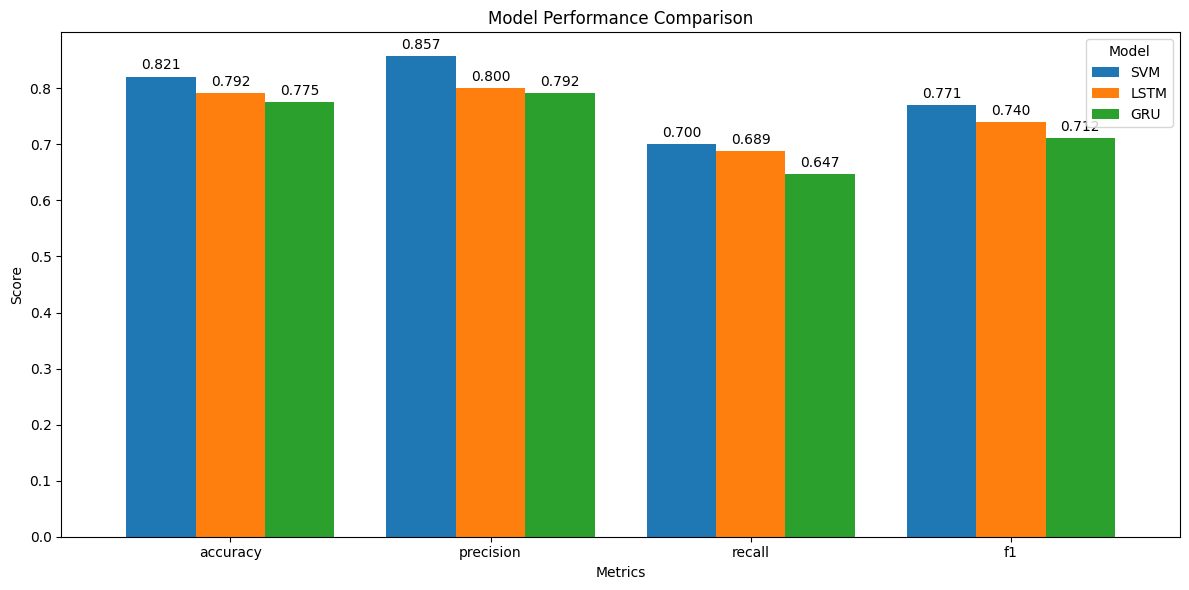

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cross_validate_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        scores['accuracy'].append(accuracy_score(y_val, y_pred))
        scores['precision'].append(precision_score(y_val, y_pred))
        scores['recall'].append(recall_score(y_val, y_pred))
        scores['f1'].append(f1_score(y_val, y_pred))

    return {k: np.mean(v) for k, v in scores.items()}

def cross_validate_nn_model(create_model_func, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_shape = (X_train.shape[1], X_train.shape[2])
        model = create_model_func(input_shape)

        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=8, verbose=0)

        y_pred = (model.predict(X_val) > 0.5).astype("int32")

        scores['accuracy'].append(accuracy_score(y_val, y_pred))
        scores['precision'].append(precision_score(y_val, y_pred))
        scores['recall'].append(recall_score(y_val, y_pred))
        scores['f1'].append(f1_score(y_val, y_pred))

    return {k: np.mean(v) for k, v in scores.items()}

svm_scores = cross_validate_svm(svm_model, train_features_pooled, target)
lstm_scores = cross_validate_nn_model(create_lstm_model, train_features, target)
gru_scores = cross_validate_nn_model(create_gru_model, train_features, target)

results = pd.DataFrame({
    'SVM': svm_scores,
    'LSTM': lstm_scores,
    'GRU': gru_scores
})

print(results.to_string(float_format='{:.3f}'.format))

ax = results.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

# 3. Enhancing Model Robustness



In [18]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np

In [19]:
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gbm_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [ ]:
# Bagging
bagging_clf = BaggingClassifier(estimator=svm_clf, n_estimators=5, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
bagging_scores = cross_val_score(bagging_clf, train_features_pooled, target, cv=kf, scoring='f1')
print(f"Bagging F1 Score: {np.mean(bagging_scores)}")

Bagging F1 Score: 0.7764360346360005


In [ ]:
# Boosting
boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
boosting_scores = cross_val_score(boosting_clf, train_features_pooled, target, cv=kf, scoring='f1')
print(f"Boosting F1 Score: {np.mean(boosting_scores)}")

Boosting F1 Score: 0.7471109849763561


In [ ]:
# compare the model robustness
print(f"Bagging F1 Score: {np.mean(bagging_scores)}")
print(f"Boosting F1 Score: {np.mean(boosting_scores)}")

best_ensemble_model = max(('Bagging', np.mean(bagging_scores)), ('Boosting', np.mean(boosting_scores)), key=lambda x: x[1])
print(f"Best Ensemble Model: {best_ensemble_model[0]} with F1 Score: {best_ensemble_model[1]}")

Bagging F1 Score: 0.7764360346360005
Boosting F1 Score: 0.7471109849763561
Best Ensemble Model: Bagging with F1 Score: 0.7764360346360005


In [ ]:
# save the best combo BERT + SVM + bagging
import joblib
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

svm_clf = SVC(probability=True)
bagging_clf = BaggingClassifier(estimator=svm_clf, n_estimators=5, random_state=42)

bagging_clf.fit(train_features_pooled, target)

joblib.dump(bagging_clf, 'best_model.pkl')
print("Model saved as best_model.pkl")

Model saved as best_model.pkl


# 4. for testing data

In [ ]:
#BERT preprocessing

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

test_texts = test_df['cleaned_text']
test_input_ids, test_attention_masks = bert_encode(test_texts, 60)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def extract_bert_features(input_ids, attention_masks, bert_model):
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }
    outputs = bert_model(inputs)
    return outputs.last_hidden_state

def extract_bert_features_in_batches(input_ids, attention_masks, bert_model, batch_size=8):
    features = []
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]
        batch_features = extract_bert_features(batch_input_ids, batch_attention_masks, bert_model)
        features.append(batch_features)
    return np.vstack(features)

test_features = extract_bert_features_in_batches(test_input_ids, test_attention_masks, bert_model, batch_size=8)

del test_input_ids, test_attention_masks
gc.collect()

def mean_pooling(features):
    return np.mean(features, axis=1)

test_features_pooled = mean_pooling(test_features)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#using the best model combo SVM+bagging
best_model = joblib.load('best_model.pkl')

test_predictions = best_model.predict(test_features_pooled)

0    2086
1    1177
Name: count, dtype: int64


Text(0, 0.5, 'Count')

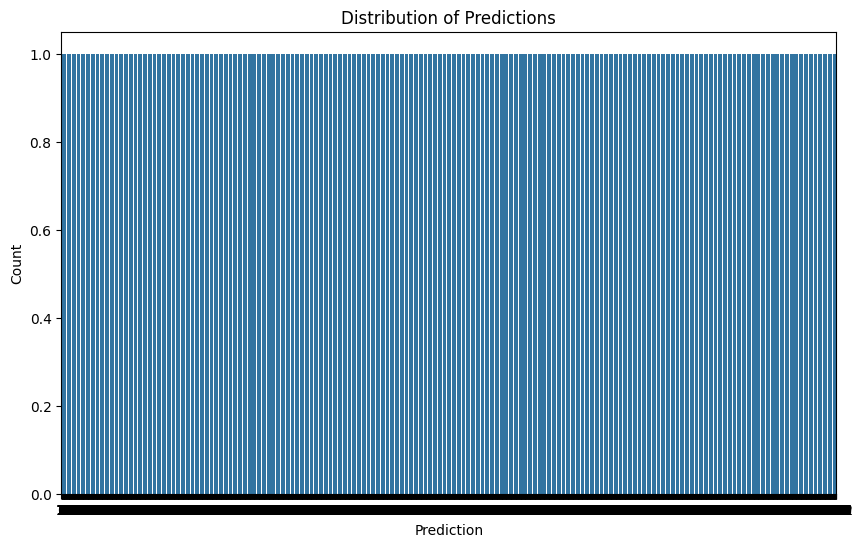

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

prediction_counts = pd.Series(test_predictions).value_counts()

print(prediction_counts)

plt.figure(figsize=(10, 6))
sns.countplot(test_predictions)
plt.title('Distribution of Predictions')
plt.xlabel('Prediction')
plt.ylabel('Count')